In [1]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_autotune_level=0"
from foundry.util.runtime import setup
setup()

import jax
import chex
import foundry.core as F
import foundry.numpy as npx

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from foundry.core import tree

from functools import partial

from policy_eval.common import Result
from policy_eval.methods.diffusion_policy import Checkpoint

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

import wandb

api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/policy-eval/final_result:v56")
checkpoint_ref = list(artifact.files())[-1]._attrs["directUrl"]
checkpoint : Checkpoint = Result.load_s3(checkpoint_ref)

In [22]:
env, splits = checkpoint.data.load({"test", "train"})
train_data = splits["train"].as_pytree()
test_data = splits["test"].as_pytree()
denoiser = checkpoint.create_denoiser()
obs_normalizer = checkpoint.obs_normalizer
act_normalizer = checkpoint.action_normalizer
schedule = checkpoint.schedule

In [23]:
test_obs = test_data.observations
test_actions = test_data.actions

sigma = 0.8

def obs_density(obs):
    def dist(other):
        chex.assert_trees_all_equal_shapes_and_dtypes(obs, other)
        obs_flat, _ = tree.ravel_pytree(obs)
        other_flat, _ = tree.ravel_pytree(other)
        return npx.sum(npx.square(obs_flat - other_flat))
    dists = jax.vmap(dist)(train_data.observations)
    log_probs = (-dists / 2*(sigma**2) - npx.log(npx.sqrt(2*npx.pi*sigma**2))) - npx.log(dists.shape[0])
    return npx.exp(jax.scipy.special.logsumexp(log_probs, axis=0))

test_densities = jax.vmap(obs_density)(test_obs)

In [43]:
def measure_ddim_ddpm_ot(rng_key, obs):
    def measure_diff(input):
        rng_key, obs = input
        def do_sample(rng_key, eta=1.0):
            obs_normalized = obs_normalizer.normalize(obs)
            action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                     act_normalizer.structure, eta=eta, final_time=2)
            return action
            # return act_normalizer.unnormalize(action)
        do_sample = jax.vmap(do_sample, in_axes=(0, None))

        ddim_rng, ddpm_rng = jax.random.split(rng_key)
        ddpm_samples = do_sample(jax.random.split(ddpm_rng, 8), 1.0)
        ddim_samples = do_sample(jax.random.split(ddim_rng, 8), 0.0)
        chex.assert_trees_all_equal_shapes_and_dtypes(ddpm_samples, ddim_samples)
        ddpm_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddpm_samples)
        ddim_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddim_samples)

        # jax.debug.print("{}", npx.linalg.norm(ddpm_samples - ddim_samples))
        # jax.debug.print("{} {}", ddpm_samples[0], ddim_samples[0])

        geom = pointcloud.PointCloud(
                ddpm_flat, ddim_flat, epsilon=1e-5
        )
        prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=4_000)
        out = solver(prob)
        return out.converged, out.reg_ot_cost
    
    return jax.lax.map(measure_diff,
        (jax.random.split(rng_key, tree.axis_size(obs)), obs), 
        batch_size=64
    )

converged, test_ddpm_ot = measure_ddim_ddpm_ot(
    jax.random.key(42), 
    tree.map(lambda x: x[:100], test_obs)
)

print(test_ddpm_ot)

[0.07174709 0.0786393  0.07009818 0.07610442 0.08126095 0.07734993
 0.07386042 0.07080198 0.07815006 0.08215835 0.08455303 0.0692828
 0.07462432 0.06374291 0.0648482  0.06841305 0.05844906 0.06371334
 0.07281902 0.06356075 0.07549502 0.0773299  0.06139591 0.0654185
 0.06603267 0.06267382 0.07217814 0.07441548 0.07161167 0.07464053
 0.06638172 0.0714381  0.07188442 0.07618359 0.06841304 0.07508112
 0.05714633 0.07662989 0.06966998 0.07017925 0.07110431 0.07021359
 0.06912448 0.0659354  0.0676625  0.06426838 0.0670245  0.06738402
 0.07044819 0.07485702 0.07357719 0.06850174 0.06539943 0.07462718
 0.05578831 0.05627373 0.06636454 0.06565567 0.06871918 0.07218483
 0.06949165 0.06977584 0.07480934 0.07974365 0.0715244  0.07084826
 0.0745099  0.06207541 0.07630282 0.07289676 0.06983452 0.07265022
 0.07590512 0.07848705 0.0684102  0.06761625 0.06001977 0.05485564
 0.0658081  0.07445695 0.06357842 0.06805304 0.07859495 0.06500319
 0.06261329 0.06505946 0.07016163 0.06942443 0.06784705 0.069180

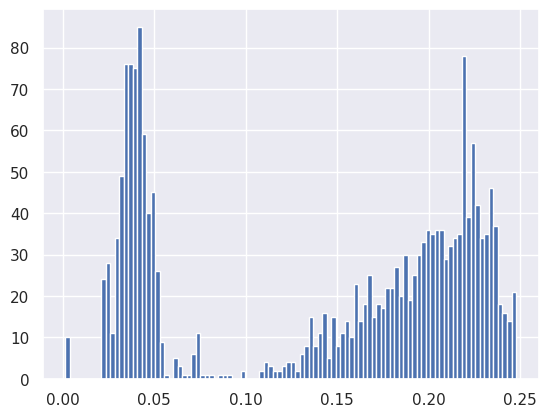

In [45]:
plt.hist(test_densities, bins=100)
plt.show()

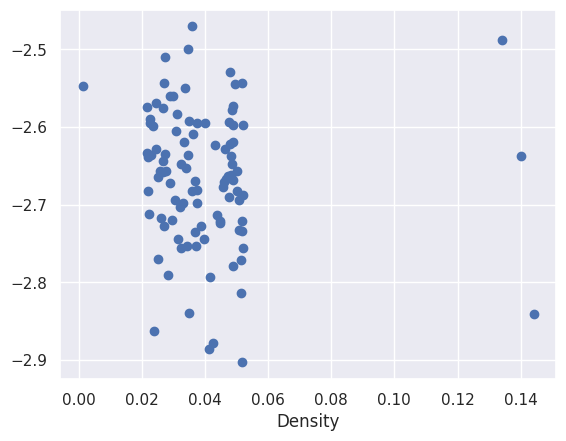

In [46]:
plt.scatter(test_densities[:test_ddpm_ot.shape[0]], test_ddpm_ot)
plt.xlabel("Log OT distance")
plt.xlabel("Density")
plt.show()